This notebook compares the two methods in generating the distribution of the test statistic used in a Facebook lift study - lift ($L$).

In [1]:
import numpy as np
import numpy.random as rdn
import matplotlib.pyplot as plt
from scipy.stats import kstest
from scipy.stats import mannwhitneyu
from scipy.stats import poisson
from scipy.optimize import brentq

# Specify the distributions

Lift is defined as:

$$L = \frac{C_T - C_S}{R_S} $$

We specify the lift distribution ($L$) in two ways:

1. A CMF implementing the derived mathematical distribution of $L$, with early stopping once the sum is deemed to have converged
2. A simulated distribution, where we draw a number of samples from $C_T$ and $C_C$, scale the latter as necessary to obtain $C_S$ and $R_S$, and obtain the empirical distribution of the quotient of the samples.

In [2]:
def lift_cmf(l, lambda_T, lambda_C, scale, r, tol=1e-10, verbose=False):
    # Sum until k > lambda_C + 3 * sqrt(lambda_C)
    # or j > lambda_T + 3 * sqrt(lambda_T)
    # => (l + 1/r)*rs *k > lambda_T + 3 * sqrt(lambda_T)
    
    MIN_K_TO_SUM_UNTIL = max(lambda_C + 3 * np.sqrt(lambda_C),
                             (lambda_T + 3 * np.sqrt(lambda_T)) / (r * scale * (l + 1/ r)))
    
    NUM_K_IN_EACH_ITER = 100
    
    acc = 0
    sum_llimit = 0
    
    def _lift_cmf_inner(k, lambda_T):
        j = np.arange(0, (l + 1/r) * k * (r * scale))
        return np.sum(poisson.pmf(j, lambda_T))
    
    inner_sum_func = np.vectorize(_lift_cmf_inner)
    
    while True:
        k = np.arange(sum_llimit, sum_llimit + NUM_K_IN_EACH_ITER)
        
        terms_sum = np.sum(poisson.pmf(k, lambda_C) * inner_sum_func(k, lambda_T))
        
        acc += terms_sum
        
        if (terms_sum < tol) & (sum_llimit > MIN_K_TO_SUM_UNTIL):
            # Round to the tolerance to avoid floating pouint error
            return round(acc, int(-np.log10(tol)))
        
        sum_llimit += NUM_K_IN_EACH_ITER

lift_cmf_vectorized = np.vectorize(lift_cmf)

In [3]:
lift_cmf(0, 11000, 5500, 2, 0.9)

0.4995119717

In [4]:
def get_lift_empirical_distribution(lambda_T, lambda_C, scale, reach, num_samples=100000):
    C_T = rdn.poisson(lambda_T, num_samples)
    C_C = rdn.poisson(lambda_C, num_samples)

    C_S = C_C * scale
    R_S = C_S * reach
    
    return (C_T - C_S) / R_S

# Plot the derived CMF and the cumulative histogram of the samples

This is used as a visual indication showing if the two distributions are equivalent or not. The two distributions should largely overlap. If they do not, it might due to:

* The bulk of the cumulative mass lie outside the range of [-0.25, 0.25]. While the CMF will take that into account, the cumulative histogram only take into samples in this range, and hence if 20% of them is below -0.25, then they will be ignored, changing the shape of the cumulative histogram.
* The distributions are not equivalent


In [67]:
def plot_cmf_empirical_comparison(lambda_T, lambda_C, scale, reach):
    fig = plt.figure(figsize=(2.5, 2))
    
    ax = fig.add_subplot(1, 1, 1)
    
    NUM_SAMPLES = 1000

    l_ulimit=0.25
    l_llimit=-0.25

    cmf_x = np.arange(l_llimit, l_ulimit + 0.01, 0.01)

    ax.plot(cmf_x,
             lift_cmf_vectorized(cmf_x, lambda_T, lambda_C, scale, reach),
             color='blue')
    ax.hist(get_lift_empirical_distribution(lambda_T, lambda_C, scale, reach, num_samples),
             range=(l_llimit, l_ulimit), bins=50, cumulative=True, normed=True, color='orange', alpha=0.5)

    ax.set_xlim(l_llimit, l_ulimit)
    ax.set_ylim(0, 1.01)

    ax.set_xlabel('Lift ($L$)')
    ax.set_ylabel('Cumulative Mass')

    return fig, ax

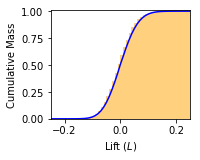

In [73]:
plt.close('all')
fig, ax = plot_cmf_empirical_comparison(1000, 1000, 1, 0.9)
plt.savefig("./cmf_empirical_comparison_1.pdf", bbox_inches='tight')
fig

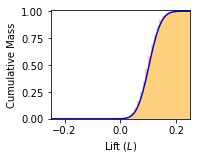

In [70]:
fig, ax = plot_cmf_empirical_comparison(4644, 7189, 0.6088, 0.5916)
fig.savefig("./cmf_empirical_comparison_2.pdf", bbox_inches='tight')
fig

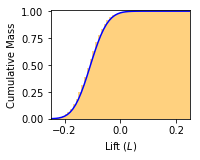

In [71]:
fig, ax = plot_cmf_empirical_comparison(3745, 3009, 1.3121, 0.4812)
fig.savefig("./cmf_empirical_comparison_3.pdf", bbox_inches='tight')
fig

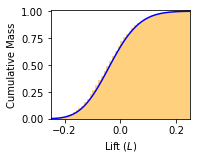

In [72]:
fig, ax = plot_cmf_empirical_comparison(2297, 408, 5.7654, 0.6361)
fig.savefig("./cmf_empirical_comparison_4.pdf", bbox_inches='tight')
fig

# Kolmogorov-Smirnov Tests

We run a number of Kolmogorov-Smirnov tests to see if the derived and simulated distributions are equivalent. At a $\alpha$% significance level, we should see around $\frac{\alpha}{100} * n$ rejections, where n is the number of tests we run.

Note: To be pedantic you can run a hypothesis test to see if the number of rejections $R$ are too high, modelling $R \sim Po(\frac{\alpha}{100} * n)$, though I would say running this test on the result of multiple K-S tests, which confirms a simulated distribution is equivalent to a derived distribution of a statistic used in a test is probably too meta.

In [6]:
def print_params(lambda_T, lambda_C, scale, reach):
    print("lambda_T:", lambda_T, 
              "lambda_C:", lambda_C, 
              "scale:", scale,
              "reach:", reach)

def get_random_parameters(verbose=False):
    lambda_T = int(rdn.uniform(1000, 5000))
    
    control_prop = rdn.uniform(0.1, 0.9)
    scale = (1 - control_prop) / control_prop
    
    lambda_C = int(lambda_T / scale * rdn.normal(1, 0.1))
    reach = rdn.uniform(0.1, 1)
    
    # If verbose, print the random parameters generated
    if verbose:
        print_params(lambda_T, lambda_C, scale, reach)
    
    return lambda_T, lambda_C, scale, reach

In [56]:
NUM_TRIALS = 100
NUM_SAMPLES_IN_KSTEST = 42
SIGNIFICANCE_LEVEL = 0.05

num_significant_ks_test = 0

for i in range(0, NUM_TRIALS):
    print("Run", i, "------")
    lambda_T, lambda_C, scale, reach = get_random_parameters(True)

    test_stat, p_val = kstest(
        get_lift_empirical_distribution(lambda_T, lambda_C, scale, reach, NUM_SAMPLES_IN_KSTEST),
        lambda x: lift_cmf_vectorized(x, lambda_T, lambda_C, scale, reach, verbose=True)
    )

    print("p-value: ", p_val)

    if p_val < SIGNIFICANCE_LEVEL:
        num_significant_ks_test += 1
        
print("Number of K-S Tests returning a significant result:",
      num_significant_ks_test, "/", NUM_TRIALS)

Run 0 ------
lambda_T: 1229 lambda_C: 1298 scale: 1.040031994478841 reach: 0.5109564529587906
p-value:  0.938644588446
Run 1 ------
lambda_T: 4836 lambda_C: 4108 scale: 1.1252492393024567 reach: 0.11161951301684969
p-value:  0.799675507609
Run 2 ------
lambda_T: 3860 lambda_C: 15277 scale: 0.2805244621828314 reach: 0.20037834273375632
p-value:  0.943269391442
Run 3 ------
lambda_T: 3877 lambda_C: 2695 scale: 1.2579122831532716 reach: 0.8461223287717292
p-value:  0.622375817365
Run 4 ------
lambda_T: 4866 lambda_C: 986 scale: 4.268656097141835 reach: 0.5394015115173694
p-value:  0.789608409986
Run 5 ------
lambda_T: 4883 lambda_C: 1711 scale: 2.7301395315332173 reach: 0.9424693733484883
p-value:  0.962936502788
Run 6 ------
lambda_T: 4141 lambda_C: 4820 scale: 0.8711361595467574 reach: 0.9707218255091562
p-value:  0.828914125947
Run 7 ------
lambda_T: 1213 lambda_C: 1392 scale: 0.8109384405431249 reach: 0.10687725737735022
p-value:  0.839200997012
Run 8 ------
lambda_T: 4895 lambda_C: 2

# Speed test

We also capture the time taken for the derived and simulated distributions to find the 95th percentile of the distribution, which is used as the critical value and hence power and required sample size calculations.

This compares the time taken to:
* (Simulated distribution) Find the 95th percentile from a large number of, say 10M, samples simulating the distribution
* (Derived distribution) Find the root of the function $F_L(l) - 0.95$ with the root-finding method proposed by Brent.

The distributions used the same set of randomly generated parameters to maintain fairness.

In [52]:
NUM_RUNS = 200
NUM_EMPIRICAL_SAMPLES = 10000000

TARGET_PERCENTILE = 95


In [53]:
%%time

# Empirical distribution

params_list = []

for i in range(0, NUM_RUNS):
    print("Run", i + 1, "------")
    
    lambda_T, lambda_C, scale, reach = get_random_parameters(True)
    
    print("95th percentile:", 
              np.percentile(
                  get_lift_empirical_distribution(lambda_T, lambda_C, scale, 
                                                  reach, NUM_EMPIRICAL_SAMPLES),
              TARGET_PERCENTILE))
    
    params_list.append((lambda_T, lambda_C, scale, reach))

Run 1 ------
lambda_T: 1504 lambda_C: 11295 scale: 0.1358382719055278 reach: 0.7619077016274637
95th percentile: 0.0326668340227
Run 2 ------
lambda_T: 3476 lambda_C: 3139 scale: 1.1740875055994378 reach: 0.653656107700511
95th percentile: -0.0272816180329
Run 3 ------
lambda_T: 3606 lambda_C: 2644 scale: 1.3468964226795035 reach: 0.3425246369993243
95th percentile: 0.164164210276
Run 4 ------
lambda_T: 3062 lambda_C: 376 scale: 7.713476474924956 reach: 0.511832477641232
95th percentile: 0.308881897116
Run 5 ------
lambda_T: 3962 lambda_C: 11356 scale: 0.35809381797045303 reach: 0.36639968876850115
95th percentile: 0.0112992856748
Run 6 ------
lambda_T: 1126 lambda_C: 680 scale: 1.7489830262575632 reach: 0.6455797867039976
95th percentile: 0.0407132457704
Run 7 ------
lambda_T: 4963 lambda_C: 5353 scale: 0.8965053167802525 reach: 0.3865789799493464
95th percentile: 0.176505878185
Run 8 ------
lambda_T: 4628 lambda_C: 3825 scale: 1.3424029356738387 reach: 0.3496811433197129
95th percent

In [54]:
%%time

# Derived distribution, using same parameters generated for the simulated distributions

for params in params_list:
    print("Run", params_list.index(params) + 1, "------")
    lambda_T, lambda_C, scale, reach = params
    
    print_params(lambda_T, lambda_C, scale, reach)
    
    try:
        print("95th percentile:", 
                  brentq(lambda l: lift_cmf_vectorized(l, lambda_T, lambda_C, scale, reach) - 
                                   TARGET_PERCENTILE / 100,
                         a=-1, b=1, xtol=1e-06))
        
    except:
        print("Failed due to an exception.")

Run 1 ------
lambda_T: 1504 lambda_C: 11295 scale: 0.1358382719055278 reach: 0.7619077016274637
95th percentile: 0.03269851502839978
Run 2 ------
lambda_T: 3476 lambda_C: 3139 scale: 1.1740875055994378 reach: 0.653656107700511
95th percentile: -0.02725084179249943
Run 3 ------
lambda_T: 3606 lambda_C: 2644 scale: 1.3468964226795035 reach: 0.3425246369993243
95th percentile: 0.16425008495559043
Run 4 ------
lambda_T: 3062 lambda_C: 376 scale: 7.713476474924956 reach: 0.511832477641232
95th percentile: 0.3088865545796839
Run 5 ------
lambda_T: 3962 lambda_C: 11356 scale: 0.35809381797045303 reach: 0.36639968876850115
95th percentile: 0.011325952809671152
Run 6 ------
lambda_T: 1126 lambda_C: 680 scale: 1.7489830262575632 reach: 0.6455797867039976
95th percentile: 0.040606829472308564
Run 7 ------
lambda_T: 4963 lambda_C: 5353 scale: 0.8965053167802525 reach: 0.3865789799493464
95th percentile: 0.17650360809031132
Run 8 ------
lambda_T: 4628 lambda_C: 3825 scale: 1.3424029356738387 reach: